In [51]:
import pandas as pd
import datetime
import re
from scipy.stats import mannwhitneyu

In [52]:
phis = pd.read_excel('./22.02.2017-reestr-licensetaxi.ru-msk.xlsx', sheet_name='Индивидуальные предприниматели')
loan = pd.read_excel('./22.02.2017-reestr-licensetaxi.ru-msk.xlsx', sheet_name='Юридические лица')

In [54]:
# Отбираем только лицензии, которые действуют сейчас
now = datetime.datetime.now()
loan = loan[pd.to_datetime(loan['Срок действия разрешения:']) > now]
phis = phis[pd.to_datetime(phis['Срок действия разрешения:']) > now]

In [ ]:
# 1. Какие марки и модели являются самыми популярными среди машин, имеющих лицензию такси?

In [56]:
models = pd.concat([loan[['Марка', 'Модель', 'Госномер']], phis[['Марка', 'Модель', 'Госномер']]])

In [57]:
# Приводим названия марок и моделей к стандартному виду: 
# В модели может быть написана модель и марка, поэтому разделяем по пробелу и '-' 
# В марке может быть несколько слов, оставляем только первое
# Приводим всё к маленьким буквам
# После преобразования ещё остаются шумные данные, их не много, поэтому можно пренебречь
models['Модель'] = models['Модель'].apply(lambda x: re.split(r'-| ', str(x))[0].lower())
models['Марка'] = models['Марка'].apply(lambda x: re.split(r'-| ', x)[0].lower())

In [58]:
# Самые популярные машины
models.groupby(['Марка', 'Модель']) \
        .count() \
        .reset_index() \
        .rename(columns={'Госномер': 'Количество машин'}) \
        .sort_values('Количество машин', ascending=False) \
        .reset_index(drop=True) \
        .head(5)

,Марка,Модель,Количество машин
0,hyundai,solaris,10196
1,kia,rio,7880
2,volkswagen,polo,3448
3,ford,focus,3327
4,renault,logan,2366


In [59]:
# 2. Выведите топ-10 компаний, владеющих лицензиями такси, а также долю рынка в машинах этих компаний.

In [70]:
all_cars = loan['Госномер'].count() + phis['Госномер'].count()

In [71]:
# Считаем, что компании только ЮЛ
company_count = loan.groupby(['ОГРН']) \
                    .agg({'Краткое наименование': "first", "Госномер": "count"}) \
                    .reset_index(drop=True) \
                    .rename(columns={'Госномер': 'Количество машин'})
company_count['Доля машин на рынке'] = company_count['Количество машин'] / all_cars

In [72]:
# Топ-10 компаний
company_count.sort_values('Количество машин', ascending=False).head(10).reset_index(drop=True)

,Краткое наименование,Количество машин,Доля машин на рынке
0,ООО “Консультант“,6471,0.100678
1,ООО “ВУЛКАН ГРУПП“,3991,0.062094
2,ООО “СИТИ-ГОЛД“,2839,0.044170
3,ООО “Мостранс“,2326,0.036189
4,ООО “ЛИТИУМ“,1708,0.026574
5,ООО “КОРТАС“,1654,0.025734
6,ООО “СССР ТАКСИ“,1395,0.021704
7,ООО “ЭЛИТПРОМГРУПП“,1262,0.019635
8,ООО “Каскад“,998,0.015527
9,ООО “ТРАНС АВТО Б“,953,0.014827


In [64]:
# 3. Отличается ли средний возраст автомобилей с лицензией такси марки Kia от автомобилей марки Hyundai?
# Является ли отличие статистически значимым?

In [65]:
models_age = pd.concat([loan[['Марка', 'Год выпуска']], phis[['Марка', 'Год выпуска']]])
models_age['Марка'] = models_age['Марка'].apply(lambda x: re.split(r'-| ', str(x))[0].lower())
models_age = models_age[models_age['Марка'].isin(['kia', 'hyundai'])]

In [66]:
models_age['Возраст'] = models_age['Год выпуска'].apply(lambda x: now.year - int(x))
models_age = models_age.drop(columns=['Год выпуска'])

In [67]:
# Средний возраст автомобилей
models_age.groupby(['Марка']).mean()

,Возраст
Марка,
hyundai,7.041879
kia,6.741594


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A6CDFA7128>,
      dtype=object)

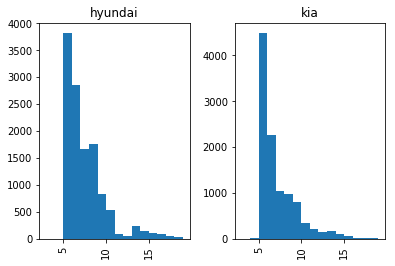

In [69]:
# Строим график распределения, по графику похоже на экспоненциальное
models_age.hist(by=['Марка'], bins=range(3,20))

In [73]:
# Проводим U тест Манна-Уитни, так как он подходит для нашего распределения
# По значению pvalue видно, что отличие средних значимое
mannwhitneyu(models_age[models_age['Марка'] == 'hyundai']['Возраст'],
            models_age[models_age['Марка'] == 'kia']['Возраст'],
            alternative='greater'
)

MannwhitneyuResult(statistic=73511800.0, pvalue=2.697308772551335e-47)